# DATA EXPLORATION

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.image import imread
from matplotlib.pyplot import imshow, subplots, axis, figure

from sklearn.model_selection import train_test_split as tts

from PIL import Image
from tqdm import tqdm
from random import randint

## Preparations and Functions

In [2]:
SEED = 42

print(os.listdir("./input"))


def get_img(img_path, size):
    w, h = size
    img = Image.open(img_path)
    img = img.resize((h,w))
    img = list(img.getdata())
    img = np.array(img)
    return img.reshape((w,h,3))

def plot_random_images(size=(299,299)):

    f, ax = subplots(3, 3, figsize=(18,18), sharex=True)
    f.subplots_adjust(hspace=0.05, wspace=0.01)
   
    for i, ax in enumerate(ax.flat):
        
        idx = randint(0, len(df))
        img_path = './input/train/{}.jpg'.format(df.iloc[idx,:].id)
        img = get_img(img_path, size)
        
        ax.imshow(img)
        xlabel = "Breed: {}".format(df.iloc[idx,:].breed)
        ax.text(20, 279, xlabel, color='w', backgroundcolor='black', fontsize=13)
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

['labels.csv', 'sample_submission.csv', 'test', 'train']


## Data Exploration

Check if number of files/images in folders corresponds to labels in description files as well as looking into train datafile

In [3]:
df = pd.read_csv('./input/labels.csv')
df_test = pd.read_csv('./input/sample_submission.csv')
breeds = df.breed.value_counts()
print('№ of train images: {:,} == {:,} : № of train labels'.format(len(os.listdir('./input/train')),len(df)))
print('№ of  test images: {:,} == {:,} : № of  test labels'.format(len(os.listdir('./input/test')),len(df_test)))
print('\n\tHead of labels.csv:\n{}'.format(df.head()))
print('\n\tDescribing breed value counts:\n{}'.format(df.describe()))

№ of train images: 10,222 == 10,222 : № of train labels
№ of  test images: 10,357 == 10,357 : № of  test labels

	Head of labels.csv:
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

	Describing breed value counts:
                                      id               breed
count                              10222               10222
unique                             10222                 120
top     785dd3642bde85cc406c55c262f2cf87  scottish_deerhound
freq                                   1                 126


We have 120 unique breeds in labels.csv. No missing breed values or train/test images
Let's visualize distribution of breeds:

	Head of breeds distribution:
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

	Tail of breeds distribution:
komondor             67
brabancon_griffon    67
golden_retriever     67
eskimo_dog           66
briard               66
Name: breed, dtype: int64


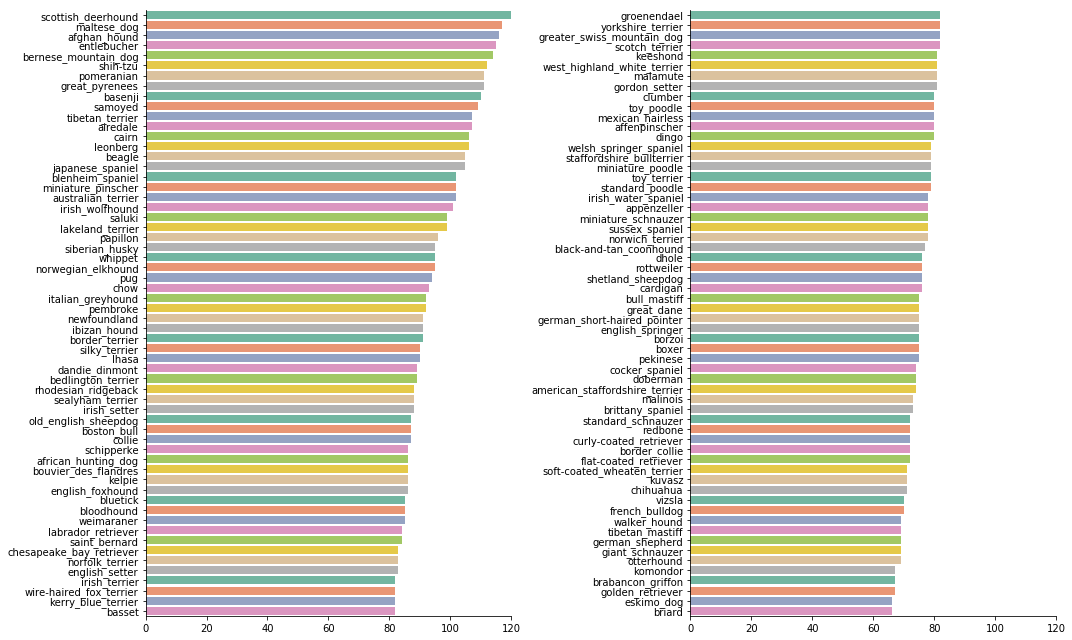

In [4]:
n = 2
s = int(120/n)
print('\tHead of breeds distribution:\n{}\n\n\tTail of breeds distribution:\n{}'.format(breeds.head(), breeds.tail()))
f, axs = subplots(ncols=n, figsize=(15, 9))
for i in range(n):
    li, ui = s*i, s*(i+1)
    ax = axs[i]
    sns.barplot(x=breeds.values[li:ui], y=breeds.index[li:ui], ax=ax, palette='Set2')
    ax.set_xlim(0, 120)
f.tight_layout()
sns.despine()

Breeds distribution seems to be skewed so we may want to augment some of the images from the lower frequency breeds to balance dataset, but not right now

#### Let's look at some of the images

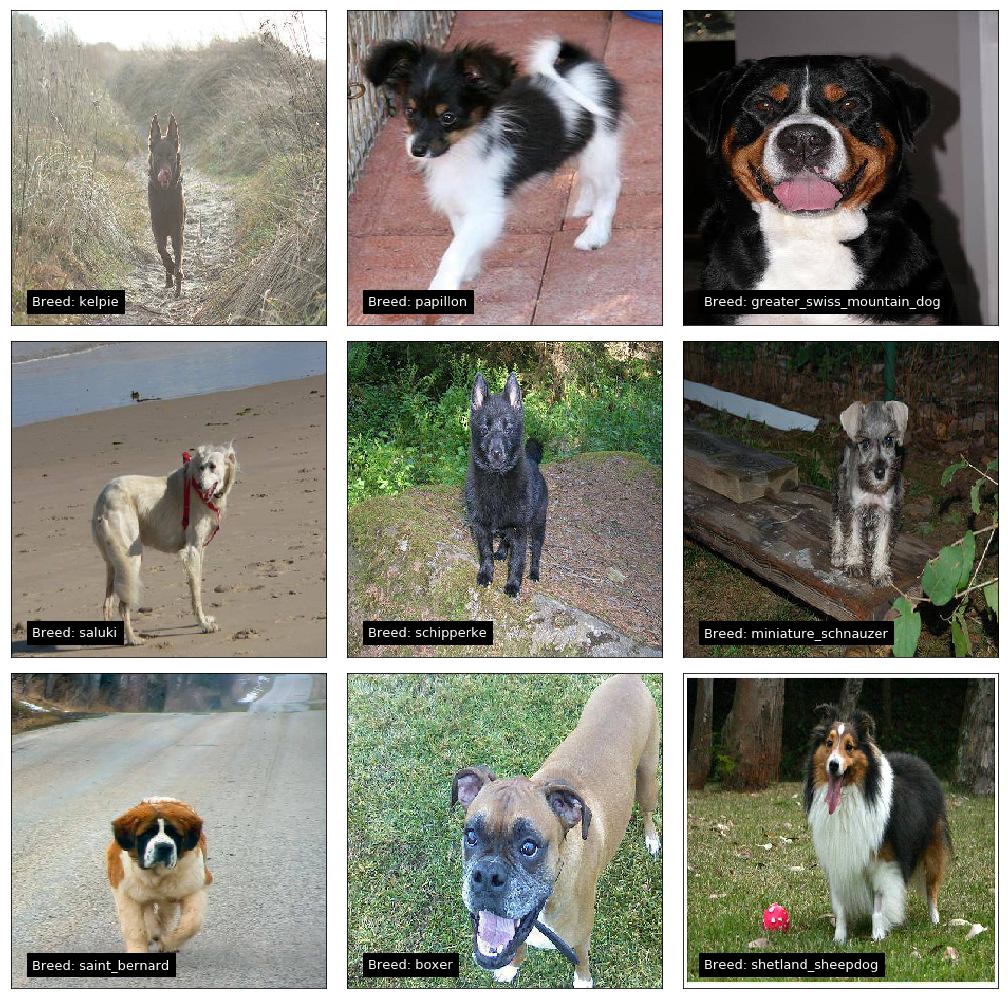

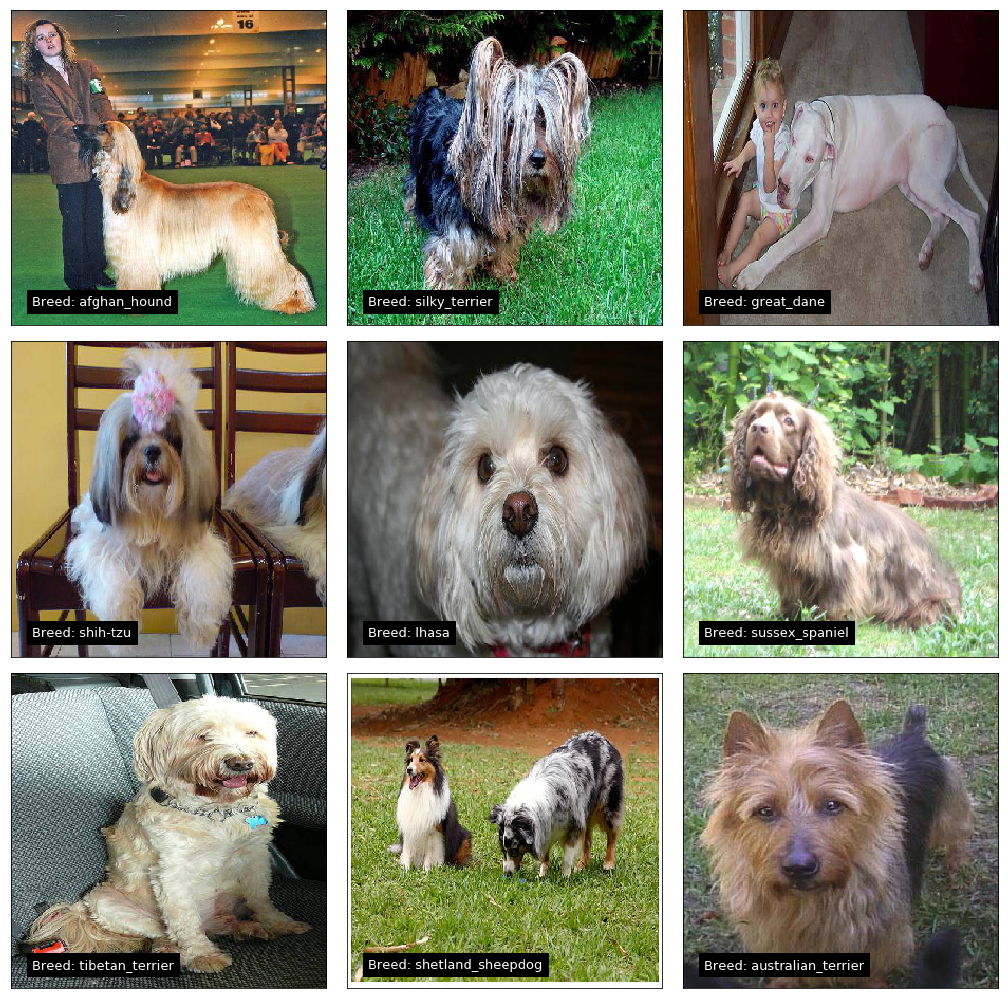

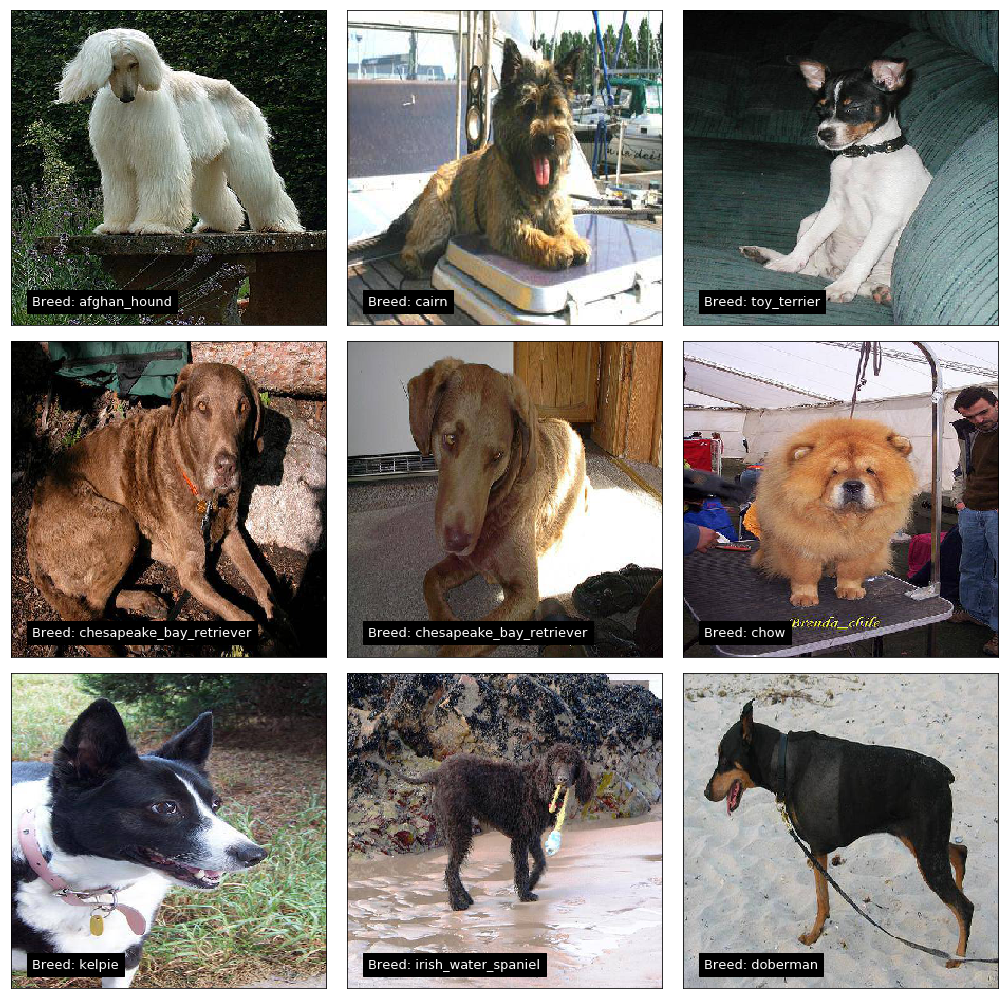

In [5]:
for i in range(3):
    plot_random_images()

Ideally we want clear pictures of dogs in "mug shot" format, but train set contains all the complications like persons, too small/big zooming, multiple dogs. In future we may want to work on our dataset, if some of the abovementioned issues will seemingly prevent our model from perfection. 

#### Now let's look to the image sizes

100%|██████████████████████████████████████████████████████████████████████████| 10222/10222 [00:01<00:00, 6792.14it/s]



	Describing image height and width:
             height        width
count  10222.000000  10222.00000
mean     386.747212    443.33154
std      130.068327    152.42012
min      102.000000     97.00000
25%      333.000000    360.00000
50%      375.000000    500.00000
75%      452.000000    500.00000
max     2562.000000   3264.00000


	Some additional quantiles for images:
         height     width
0.001   120.442   120.663
0.010   154.210   170.000
0.020   175.420   190.000
0.030   191.000   200.000
0.050   211.000   222.000
0.100   260.000   288.000
0.150   300.000   325.000
0.850   500.000   500.000
0.900   500.000   500.000
0.950   500.000   500.000
0.970   519.370   600.000
0.980   600.000   640.000
0.990   773.370   800.000
0.999  1704.000  2151.359



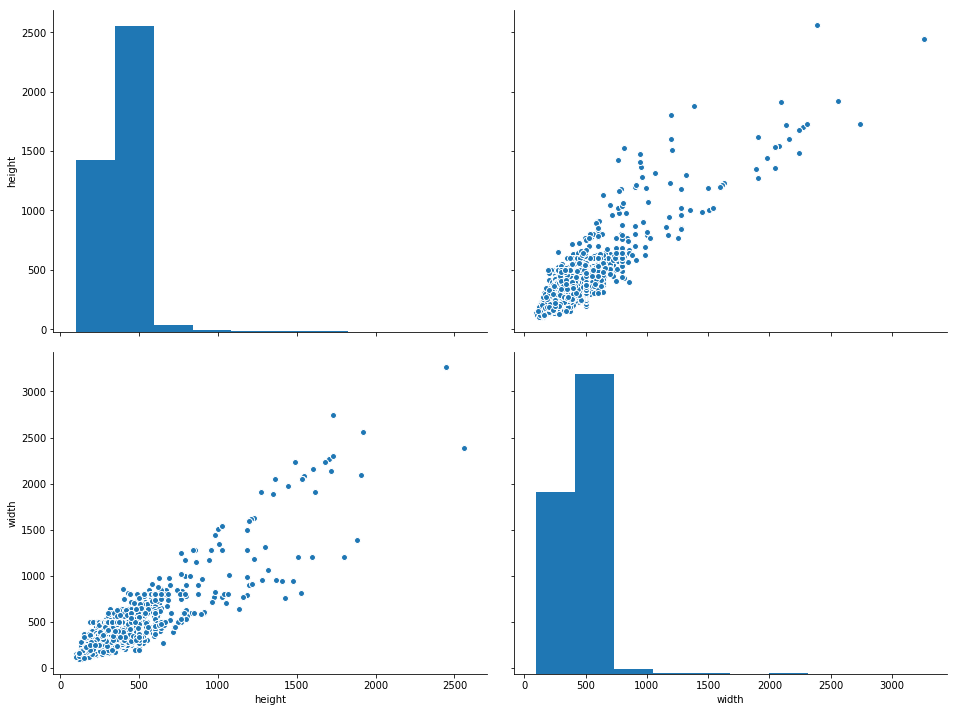

In [6]:
im_w, im_h = [], []
for f ,b in tqdm(df.values):
    im = Image.open('./input/train/{}.jpg'.format(f))
    w, h = im.size
    im_w.append(w)
    im_h.append(h)

ims = pd.DataFrame({'height': im_h, 'width': im_w})
qntls = [.001, .01, .02, .03, .05, .1, .15, .85, .9, .95, .97, .98, .99, .999]
print('\n\tDescribing image height and width:\n{}\n'.format(ims.describe()))
print('\n\tSome additional quantiles for images:\n{}\n'.format(ims.quantile(qntls)))
sns.pairplot(ims, size=5, aspect=4/3)
plt.show()

Later on we will resize all the pictures at (299, 299). Due to this charts and tables it seems to be ok almost for 90% of data (assuming there are some issues if resizing from smaller sizes to bigger ones)

#### About train/validation split
This is the way to split data by keeping class distribution, so validation set contains all the breeds from the train data. We will do it in Model Training by indices because of memory issues (if I try to do it on image_as_arrays-matricies I will catch memory exception from numpy)

Also doing it this way helps us to transfer data approach between Jupyter Notebooks, but we need to keep SEED and test_size variables the same

Look at our future train/valid split:


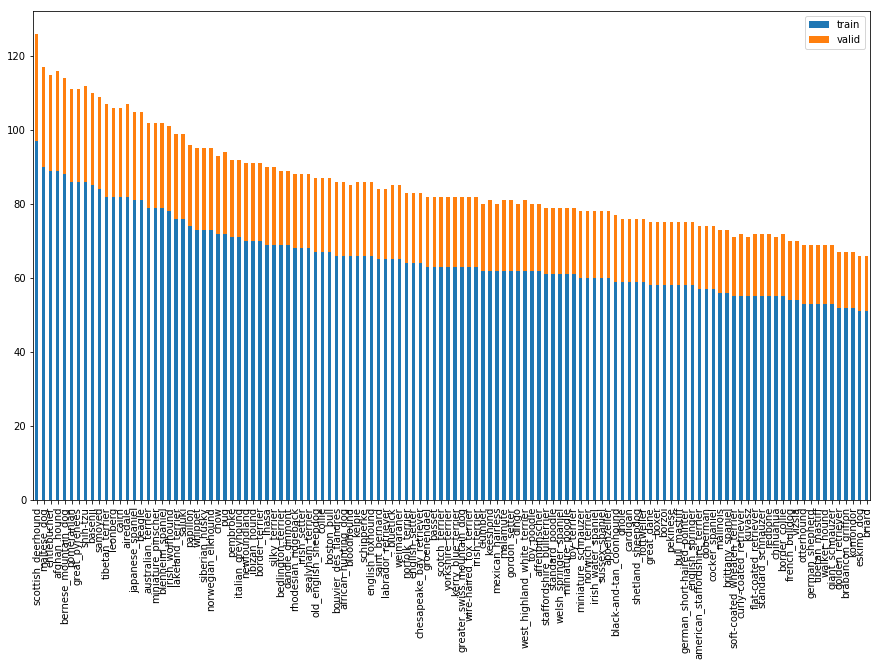

In [7]:
tridx, vaidx = tts(range(len(df)), test_size=2345, stratify=df.breed, random_state=SEED)

tr_breeds = df.iloc[tridx].breed.value_counts()
va_breeds = df.iloc[vaidx].breed.value_counts()
d_breeds = pd.concat([tr_breeds, va_breeds], axis=1, sort=False)
d_breeds.columns = ['train', 'valid']

print('Look at our future train/valid split:')
d_breeds.plot(kind='bar', stacked=True, figsize=(15, 9))
plt.show()

Splitting data like this allowes our future train/validation sets to contain all the needed breeds in similar distribution.

## Purpose of Data Exploration

Before model training can be done, we must summarize the characteristics of a dataset: data correctness, number of cases, variables included, missing observations and any prospective hypotheses the data might support.

Data exploration aimed at creating a clear mental model and understanding of the data in the mind of the analyst, and defining basic metadata (statistics, structure, relationships) for the dataset that can be used in further analysis. It helps build a familiarity with the existing information that makes finding better answers much simpler. Visualizations allows to create a more straightforward view of data sets than by simple examining thousands of individual numbers or names.

By combining all the information about given data and keeping it in mind as a mental model we can quickly make and verify assumptions about model behaviour during training and evaluation.